In [1]:
import pandas as pd
from preprocessing.light.text_cleaner_light import TextCleaner
from preprocessing.text_tokenizer import TextTokenizer
from preprocessing.light.text_lemmatizer_light import TextLemmatizer
from preprocessing.light.stopword_remover_light import StopwordRemover
import torch
import torch.nn as nn
from embedding.fasttext import FastText
import nltk
import os

from bs4 import MarkupResemblesLocatorWarning
import warnings

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

nltk_dir = 'nltk_data'
nltk.data.path.append(os.path.abspath(nltk_dir))

In [2]:
df = pd.read_csv('./data/sentiment_data.csv')

In [3]:
df.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


In [4]:
df_shortened = df.sample(n=50000)
df_shortened.head()

,Unnamed: 0,Comment,Sentiment
189190,189968,party reached stage bjp modi modi entire cabin...,2
169799,170577,modi put stop kind patronage wonder shameless ...,2
121506,122284,saare news channels script likh rahe hain brea...,1
112713,113491,already done enoughand blame thrown modiare in...,2
182217,182995,hope common sense prevail people difference op...,0


# Preprocessing

In [5]:
TextCleaner = TextCleaner()
df_cleaned = df_shortened.copy()
for index, row in df_shortened.iterrows():
    df_cleaned.at[index, 'Comment'] = TextCleaner.clean_text(row['Comment'])

df_cleaned.head()

,Unnamed: 0,Comment,Sentiment
189190,189968,party reached stage bjp modi modi entire cabin...,2
169799,170577,modi put stop kind patronage wonder shameless ...,2
121506,122284,saare news channels script likh rahe hain brea...,1
112713,113491,already done enoughand blame thrown modiare in...,2
182217,182995,hope common sense prevail people difference op...,0


In [6]:
TextTokenizer = TextTokenizer()
df_tokenised = df_cleaned.copy()
for index, row in df_cleaned.iterrows():
    df_tokenised.at[index, 'Comment'] = TextTokenizer.tokenize(row['Comment'])

df_tokenised.head()

,Unnamed: 0,Comment,Sentiment
189190,189968,"[party, reached, stage, bjp, modi, modi, entir...",2
169799,170577,"[modi, put, stop, kind, patronage, wonder, sha...",2
121506,122284,"[saare, news, channels, script, likh, rahe, ha...",1
112713,113491,"[already, done, enoughand, blame, thrown, modi...",2
182217,182995,"[hope, common, sense, prevail, people, differe...",0


In [7]:
StopwordRemover = StopwordRemover()
df_stopwords_removed = df_tokenised.copy()
for index, row in df_tokenised.iterrows():
    df_stopwords_removed.at[index, 'Comment'] = StopwordRemover.remove_stopwords(row['Comment'])

df_stopwords_removed.head()

,Unnamed: 0,Comment,Sentiment
189190,189968,"[party, reached, stage, bjp, modi, modi, entir...",2
169799,170577,"[modi, put, stop, kind, patronage, wonder, sha...",2
121506,122284,"[saare, news, channels, script, likh, rahe, ha...",1
112713,113491,"[already, done, enoughand, blame, thrown, modi...",2
182217,182995,"[hope, common, sense, prevail, people, differe...",0


In [8]:
TextLemmatizer = TextLemmatizer()
df_lemmatised = df_stopwords_removed.copy()
for index, row in df_stopwords_removed.iterrows():
    df_lemmatised.at[index, 'Comment'] = TextLemmatizer.lemmatize(row['Comment'])

df_lemmatised.head()


,Unnamed: 0,Comment,Sentiment
189190,189968,"[party, reach, stage, bjp, modi, modi, entire,...",2
169799,170577,"[modi, put, stop, kind, patronage, wonder, sha...",2
121506,122284,"[sare, news, chanels, script, likh, rahe, hain...",1
112713,113491,"[already, do, enoughand, blame, thrown, modiar...",2
182217,182995,"[hope, comon, sense, prevail, people, diferenc...",0


In [9]:
empty_comments = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")
	print(empty_comments.index.tolist())

df_lemmatised = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) > 0)]

empty_comments = df_lemmatised[df_lemmatised['Comment'].apply(lambda x: len(x) == 0)]
print("Number of empty comments:", len(empty_comments))

if len(empty_comments) > 0:
	print("\nEmpty comments found at indices:")

Number of empty comments: 45

Empty comments found at indices:
[20973, 65862, 131864, 233352, 68637, 33840, 68252, 128365, 128457, 28288, 77953, 7496, 129986, 42212, 101012, 153120, 20966, 51873, 37110, 121091, 123543, 218757, 39428, 62065, 105422, 45945, 102323, 86186, 19791, 42706, 71700, 118762, 58555, 162023, 76099, 45572, 22910, 23110, 63077, 49049, 189786, 100163, 51967, 119739, 116012]
Number of empty comments: 0


In [10]:
all_tokens = []
for index, row in df_lemmatised.iterrows():
	all_tokens.extend(row['Comment'])

vocab = set(all_tokens)
vocab_to_idx = {'<PAD>': 0, '<UNK>': 1}
for token in vocab:
	vocab_to_idx[token] = len(vocab_to_idx)

idx_to_vocab = {idx: token for token, idx in vocab_to_idx.items()}

print(f"Vocabulary size: {len(vocab_to_idx)}")
print("Sample tokens:", list(vocab_to_idx.keys())[:10])

Vocabulary size: 52382
Sample tokens: ['<PAD>', '<UNK>', 'korea', 'slander', 'oregan', 'teroists', 'contestanthis', 'pranayam', 'kare', 'poise']


In [11]:
def tokens_to_indices(tokens, vocab_to_idx):
	return [vocab_to_idx.get(token, vocab_to_idx['<UNK>']) for token in tokens]

df_indices = df_lemmatised.copy()
for index, row in df_lemmatised.iterrows():
	df_indices.at[index, 'Comment'] = tokens_to_indices(row['Comment'], vocab_to_idx)

print("Sample converted to indices:")
print(df_indices['Comment'].iloc[0][:10])  # First 10 indices of first comment

Sample converted to indices:
[14342, 39503, 40618, 2316, 10015, 10015, 4889, 29283, 18529, 4035]


In [12]:
def pad_sequences(sequences, max_len, pad_value=0):
	padded = []
	for seq in sequences:
		if len(seq) > max_len:
			padded.append(seq[:max_len])
		else:
			padded.append(seq + [pad_value] * (max_len - len(seq)))  # Pad if too short
	return padded

sequence_lengths = [len(seq) for seq in df_indices['Comment']]
max_len = max(sequence_lengths)
avg_len = sum(sequence_lengths) / len(sequence_lengths)

print(f"Max sequence length: {max_len}")
print(f"Average sequence length: {avg_len:.2f}")

import numpy as np
chosen_max_len = int(np.percentile(sequence_lengths, 95))
print(f"Chosen max length (95th percentile): {chosen_max_len}")

padded_sequences = pad_sequences(df_indices['Comment'].tolist(), chosen_max_len, vocab_to_idx['<PAD>'])

print(f"Padded sequences shape: {len(padded_sequences)} x {len(padded_sequences[0])}")
print("Sample padded sequence:", padded_sequences[0][:10])


Max sequence length: 645
Average sequence length: 12.99
Chosen max length (95th percentile): 27
Padded sequences shape: 49955 x 27
Sample padded sequence: [14342, 39503, 40618, 2316, 10015, 10015, 4889, 29283, 18529, 4035]


In [13]:
from sklearn.model_selection import train_test_split

X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(df_indices['Sentiment'].values, dtype=torch.long)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Number of classes: {len(torch.unique(y))}")
print(f"Classes distribution: {torch.bincount(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Validation set: X_val {X_val.shape}, y_val {y_val.shape}")


X shape: torch.Size([49955, 27])
y shape: torch.Size([49955])
Number of classes: 3
Classes distribution: tensor([11340, 17281, 21334])
Training set: X_train torch.Size([39964, 27]), y_train torch.Size([39964])
Validation set: X_val torch.Size([9991, 27]), y_val torch.Size([9991])


# RNN Architecture (From Scratch)


In [60]:
class RNNCell(nn.Module):
	def __init__(self, input_size, hidden_size):
		super(RNNCell, self).__init__()
		self.hidden_size = hidden_size
		
		self.W_ih = nn.Linear(input_size, hidden_size, bias=True)
		self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)
		self.tanh = nn.Tanh()
		
	def forward(self, input, hidden):
		# RNN formula: h_t = tanh(W_ih * x_t + W_hh * h_{t-1} + b)
		new_hidden = self.tanh(self.W_ih(input) + self.W_hh(hidden))
		return new_hidden
	
	def init_hidden(self, batch_size, device):
		return torch.zeros(batch_size, self.hidden_size, device=device)

print("RNN Cell implemented successfully!")

In [ ]:
# Complete RNN Model for Sentiment Analysis
class SentimentRNN(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, pad_idx=0):
		super(SentimentRNN, self).__init__()
		self.hidden_size = hidden_size
		
		# Embedding layer
		self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
		
		# RNN cell
		self.rnn_cell = RNNCell(embedding_dim, hidden_size)
		
		# Output layer
		self.fc = nn.Linear(hidden_size, num_classes)
		self.dropout = nn.Dropout(0.3)
		
	def forward(self, x):
		batch_size, seq_len = x.size()
		device = x.device
		
		embedded = self.embedding(x)
		
		hidden = self.rnn_cell.init_hidden(batch_size, device)
		
		for t in range(seq_len):
			hidden = self.rnn_cell(embedded[:, t, :], hidden)
		
		# Apply dropout and final classification
		output = self.dropout(hidden)
		output = self.fc(output) 
		
		return output
	
vocab_size = len(vocab_to_idx)
embedding_dim = 64
hidden_size = 32
num_classes = 3

model = SentimentRNN(vocab_size, embedding_dim, hidden_size, num_classes)

print(f"Model created with:")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Hidden size: {hidden_size}")
print(f"- Output classes: {num_classes}")

# Training Setup


In [62]:
# Training setup
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report

# Training parameters
learning_rate = 0.001
batch_size = 32
num_epochs = 20

# Loss function for classification (not MSE!)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training setup complete:")
print(f"- Loss function: CrossEntropyLoss (for classification)")
print(f"- Optimizer: Adam")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Number of epochs: {num_epochs}")
print(f"- Training batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")


Training setup complete:
- Loss function: CrossEntropyLoss (for classification)
- Optimizer: Adam
- Learning rate: 0.001
- Batch size: 32
- Number of epochs: 20
- Training batches: 1249
- Validation batches: 313


In [63]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer):
	model.train()
	total_loss = 0
	total_correct = 0
	total_samples = 0
	
	for batch_idx, (data, target) in enumerate(train_loader):
		optimizer.zero_grad()
		
		# Forward pass
		output = model(data)
		loss = criterion(output, target)
		
		# Backward pass
		loss.backward()
		optimizer.step()
		
		# Statistics
		total_loss += loss.item()
		pred = output.argmax(dim=1)
		total_correct += (pred == target).sum().item()
		total_samples += target.size(0)
	
	avg_loss = total_loss / len(train_loader)
	accuracy = total_correct / total_samples
	return avg_loss, accuracy

# Validation function
def validate_epoch(model, val_loader, criterion):
	model.eval()
	total_loss = 0
	total_correct = 0
	total_samples = 0
	
	with torch.no_grad():
		for data, target in val_loader:
			output = model(data)
			loss = criterion(output, target)
			
			total_loss += loss.item()
			pred = output.argmax(dim=1)
			total_correct += (pred == target).sum().item()
			total_samples += target.size(0)
	
	avg_loss = total_loss / len(val_loader)
	accuracy = total_correct / total_samples
	return avg_loss, accuracy

print("Training and validation functions defined successfully!")


Training and validation functions defined successfully!


In [64]:
# Training loop with metrics tracking
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...")
print("="*50)

for epoch in range(num_epochs):
	# Train
	train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
	
	# Validate
	val_loss, val_acc = validate_epoch(model, val_loader, criterion)
	
	# Store metrics
	train_losses.append(train_loss)
	train_accuracies.append(train_acc)
	val_losses.append(val_loss)
	val_accuracies.append(val_acc)
	
	# Print metrics every 5 epochs
	if (epoch + 1) % 5 == 0 or epoch == 0:
		print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
			  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
			  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("="*50)
print("Training completed!")

# Final evaluation on validation set
model.eval()
with torch.no_grad():
	val_predictions = []
	val_true = []
	
	for data, target in val_loader:
		output = model(data)
		pred = output.argmax(dim=1)
		val_predictions.extend(pred.cpu().numpy())
		val_true.extend(target.cpu().numpy())

print(f"Final validation accuracy: {accuracy_score(val_true, val_predictions):.4f}")
print("\nClassification Report:")
print(classification_report(val_true, val_predictions, target_names=['Negative', 'Neutral', 'Positive']))


Starting training...


ValueError: not enough values to unpack (expected 3, got 2)

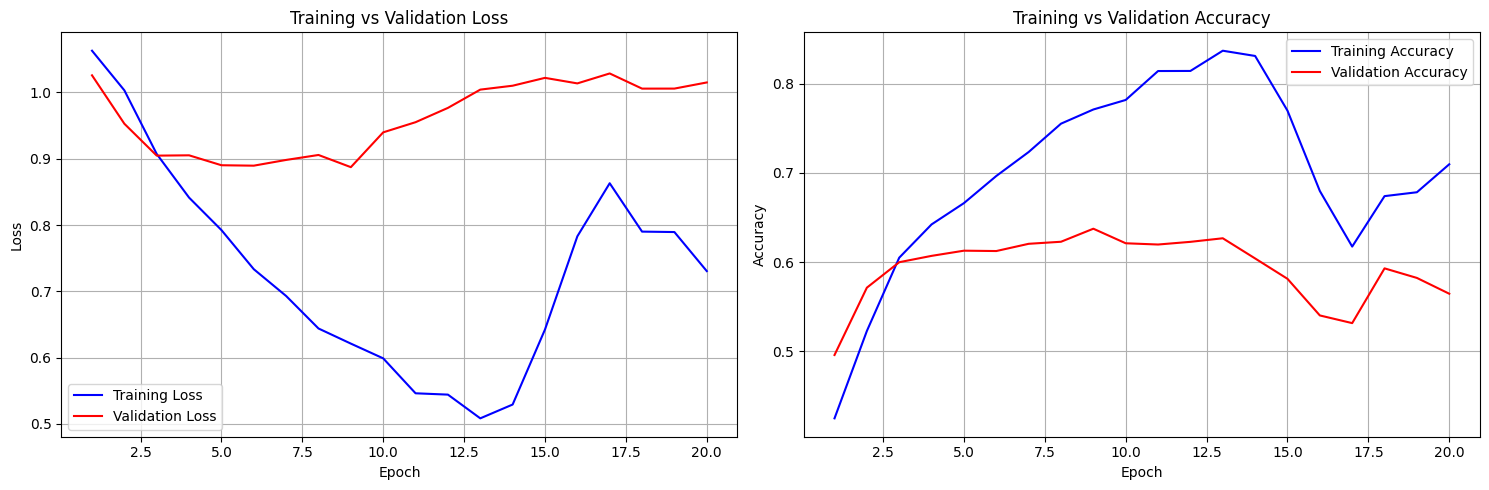

Final Results:
- Best validation accuracy: 0.6375
- Final training accuracy: 0.7097
- Final validation accuracy: 0.5646
⚠️  Possible overfitting detected (train acc >> val acc)


In [41]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Results:")
print(f"- Best validation accuracy: {max(val_accuracies):.4f}")
print(f"- Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"- Final validation accuracy: {val_accuracies[-1]:.4f}")

if train_accuracies[-1] - val_accuracies[-1] > 0.1:
	print("⚠️  Possible overfitting detected (train acc >> val acc)")
else:
	print("✅ Model seems to generalize well")


In [42]:
# Test model with a small batch to verify shapes
print("Testing model with sample data...")
print("="*40)

# Take a small sample
test_batch = X_train[:3]  # First 3 samples
print(f"Input shape: {test_batch.shape}")

# Forward pass
model.eval()
with torch.no_grad():
	test_output = model(test_batch)
	print(f"Output shape: {test_output.shape}")
	
	# Get predictions
	test_predictions = test_output.argmax(dim=1)
	print(f"Predictions: {test_predictions}")
	print(f"True labels: {y_train[:3]}")

print("\n✅ Model is working correctly!")
print(f"📊 Votre RNN from scratch est maintenant prêt et fonctionnel!")
print(f"📈 Architecture complète: Embedding → RNN Cell → Classification")


Testing model with sample data...
Input shape: torch.Size([3, 27])
Output shape: torch.Size([3, 3])
Predictions: tensor([2, 2, 2])
True labels: tensor([0, 2, 2])

✅ Model is working correctly!
📊 Votre RNN from scratch est maintenant prêt et fonctionnel!
📈 Architecture complète: Embedding → RNN Cell → Classification


In [ ]:
# ✅ RNN from scratch CORRECT (sans erreur de dimension)
class SimpleRNN(nn.Module):
	def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, pad_idx=0):
		super(SimpleRNN, self).__init__()
		self.hidden_size = hidden_size
		self.embedding_dim = embedding_dim
		
		# Embedding layer - OBLIGATOIRE !
		self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
		
		# RNN weights (from scratch formula!)
		self.W_ih = nn.Linear(embedding_dim, hidden_size, bias=True)  # Input to hidden
		self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)    # Hidden to hidden
		
		# Output layer
		self.fc = nn.Linear(hidden_size, num_classes)
		self.dropout = nn.Dropout(0.3)
		
	def forward(self, x):
		# x shape: (batch_size, seq_len) = (32, 27)
		batch_size, seq_len = x.size()  # ✅ CORRECT: seulement 2 dimensions !
		device = x.device
		
		# 1. Embedding: indices → vecteurs
		embedded = self.embedding(x)  # (32, 27) → (32, 27, 64)
		
		# 2. Initialize hidden state
		h_t = torch.zeros(batch_size, self.hidden_size, device=device)  # (32, 16)
		
		# 3. RNN from scratch - Process sequence step by step
		for t in range(seq_len):
			x_t = embedded[:, t, :]  # (32, 64) - embedding au temps t
			
			# ✅ FORMULE RNN: h_t = tanh(W_ih * x_t + W_hh * h_{t-1})
			h_t = torch.tanh(self.W_ih(x_t) + self.W_hh(h_t))
		
		# 4. Classification finale
		output = self.dropout(h_t)  # (32, 16)
		output = self.fc(output)    # (32, 16) → (32, 3)
		
		return output

print("✅ SimpleRNN créé sans erreur de dimension!")
print("🔥 Formule RNN implémentée: h_t = tanh(W_ih * x_t + W_hh * h_{t-1})")


In [ ]:
# Créer le nouveau modèle SimpleRNN
vocab_size = len(vocab_to_idx)
embedding_dim = 32  # Réduit pour éviter overfitting
hidden_size = 16    # Réduit pour éviter overfitting  
num_classes = 3

# Nouveau modèle corrigé
model_simple = SimpleRNN(vocab_size, embedding_dim, hidden_size, num_classes, vocab_to_idx['<PAD>'])

print(f"✅ Modèle SimpleRNN créé avec:")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Hidden size: {hidden_size}")
print(f"- Number of classes: {num_classes}")
print(f"- Total parameters: {sum(p.numel() for p in model_simple.parameters() if p.requires_grad)}")

# Test du modèle avec un petit batch
print("\n🧪 Test du modèle:")
test_batch = X_train[:2]  # 2 échantillons
print(f"Input shape: {test_batch.shape}")

model_simple.eval()
with torch.no_grad():
	test_output = model_simple(test_batch)
	print(f"Output shape: {test_output.shape}")
	print("✅ Pas d'erreur de dimension ! Le modèle marche !")
